In [1]:
### Testing preprocessing functions from original paper (Konstantin Georgiev)
import sys
sys.path.append("../")

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

from skimage.io import imread, imshow
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.filters import gaussian
from skimage import data, color

from utils import crop, flip_and_rotate, rgb2ycbcr, calculate_psnr

#### Load an image and get HR/LR

In [2]:
def plot_img(img, figsize=(8,8)):
    plt.figure(figsize=figsize)
    imshow(img)
    plt.axis('off')
    plt.show()
    
def blur_img(img, sigma=2, truncate=2.5, multichannel=True):
    blurred = gaussian(img, sigma=sigma, truncate=truncate, multichannel=multichannel)
    return blurred

def downsample_img(img, factor=2):
    downsampled = resize(img, (img.shape[0] // factor, img.shape[1] // factor), order=1, mode='reflect', 
                             clip=True, preserve_range=True, anti_aliasing=True)
    upsampled = resize(downsampled, img.shape, order=0, mode='reflect', 
                             clip=True, preserve_range=True, anti_aliasing=False)
    return upsampled / 255

In [3]:
# These are taken from the paper but I added unsqueeze() in the im2tensor
def im2tensor(im):
    np_t = np.ascontiguousarray(im.transpose((2, 0, 1)))
    tensor = torch.from_numpy(np_t).float().unsqueeze(0)
    return tensor

def tensor2im(tensor):
    tensor = tensor.detach().squeeze(0)
    im = tensor.clamp(0, 255).round().cpu().byte().permute(1, 2, 0).numpy()
    return im

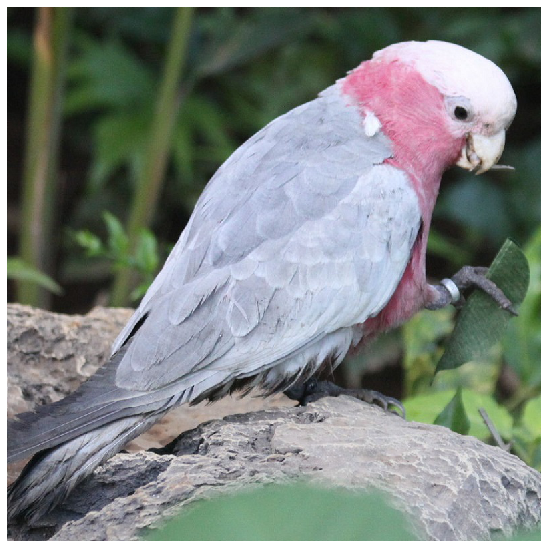

In [4]:
hr_img = imread('Galah-cockatoo.jpg')
plot_img(hr_img)

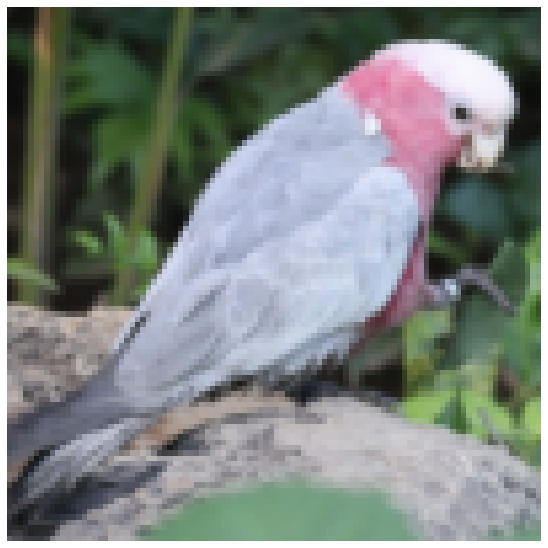

In [5]:
lr_img = blur_img(hr_img)
#lr_img = downscale_img(hr_img)
lr_img = downsample_img(hr_img, factor=8)
plot_img(lr_img)

#### Crop both images at random

In [6]:
hr_cropped, lr_cropped = hr_img.copy(), lr_img.copy()
hr_cropped_c, lr_cropped_c = crop(hr_img, lr_img, psize=200, scale=1)

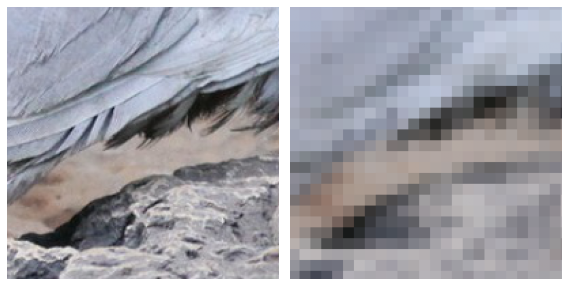

In [7]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,8))
ax[0].imshow(hr_cropped_c)
ax[0].axis('off')
ax[1].imshow(lr_cropped_c)
ax[1].axis('off')
plt.tight_layout()
plt.show()

#### Random rotation and/or flipping

In [8]:
hr_flipped, lr_flipped = hr_img.copy(), lr_img.copy()
hr_flipped_c, lr_flipped_c = flip_and_rotate(hr_flipped, lr_flipped, p=0.9)

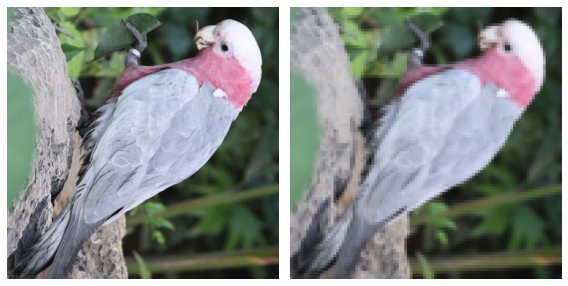

In [9]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,8))
ax[0].imshow(hr_flipped_c)
ax[0].axis('off')
ax[1].imshow(lr_flipped_c)
ax[1].axis('off')
plt.tight_layout()
plt.show()

#### Convert RGB image to YCBCR

In [10]:
hr_ycbcr, lr_ycbcr = hr_img.copy(), lr_img.copy()
hr_ycbcr = rgb2ycbcr(hr_ycbcr)
lr_ycbcr = rgb2ycbcr(lr_ycbcr)

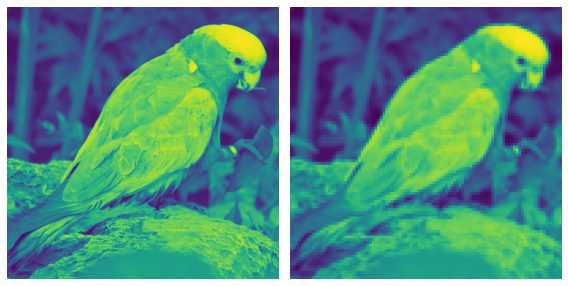

In [11]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,8))
ax[0].imshow(hr_ycbcr)
ax[0].axis('off')
ax[1].imshow(lr_ycbcr)
ax[1].axis('off')
plt.tight_layout()
plt.show()

#### Calculate PSNR (peak-signal-to-noise-ratio) for two images
![PSNR](./psnr.png)

In [12]:
psnr_base = calculate_psnr(hr_img, lr_img)
psnr_cropped = calculate_psnr(hr_cropped_c, lr_cropped_c)
psnr_flipped = calculate_psnr(hr_flipped_c, lr_flipped_c)
psnr_ycbcr = calculate_psnr(hr_ycbcr, lr_ycbcr)

print('PSNR (base):', psnr_base)
print('PSNR (cropped):', psnr_cropped)
print('PSNR (flipped):', psnr_flipped)
print('PSNR (YCBCR):', psnr_ycbcr)

PSNR (base): 5.272902849183478
PSNR (cropped): 4.162479619569208
PSNR (flipped): 5.272902849183479
PSNR (YCBCR): 5.657609888836285
